# **Table of Contents**
* [Explore & Wrangle](#section_10)
* [Assumptions Testing](#section_11)

* [Model Building](#section_12)
    * [LiR](#section_13)
    * [RF](#section_14)
    <br><br>
* [Model Selection](#section_15)
    * [Fitting](#section_16)
    * [Validation](#section_17)
    * [Best Model](#section_18)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")

import scipy.stats       as stats

from   sklearn.linear_model     import   LinearRegression
from   sklearn.ensemble         import   RandomForestRegressor

from   sklearn.model_selection  import   train_test_split , KFold , cross_val_score , RandomizedSearchCV
from   sklearn.metrics          import   mean_squared_error

<a id='section_10'></a>
# Part 1 - **Explore & Wrangle**

In [2]:
df  =  pd.read_csv ('datasets/Appliance Energy.csv')

pd.set_option      ('display.max_columns' , None)

df.sample(5)

,AE,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility
511,50,0,24.890000,38.863333,23.963333,37.626667,25.39,37.59,24.39,37.500000,22.70,58.133333,15.000000,12.516000,23.70,37.114286,25.1,43.116000,22.39,40.340000,16.333333,751.666667,68.666667,1.000000,40.000000
339,50,0,23.790000,37.700000,21.700000,39.090000,24.50,38.09,23.60,36.590000,21.10,48.326667,10.784286,23.422857,22.79,34.090000,23.7,43.126667,21.79,43.290000,12.100000,752.100000,65.000000,1.000000,40.000000
46,50,0,20.856667,37.223333,19.200000,36.966667,20.50,37.09,19.70,35.200000,19.39,67.240000,1.323333,64.656667,18.70,34.805714,20.6,42.863333,17.70,38.656667,2.033333,750.733333,81.000000,2.666667,21.333333
987,40,10,20.790000,40.200000,19.200000,41.590000,20.60,38.53,19.39,39.400000,19.00,46.730000,8.033333,86.263333,18.50,35.590000,20.7,48.933333,18.00,41.163333,8.400000,749.333333,85.000000,8.000000,40.000000
466,230,10,22.790000,28.193333,22.000000,26.360000,22.50,34.56,22.50,29.421429,20.29,35.433333,15.963333,1.000000,22.70,26.890000,22.2,32.663333,20.20,34.363333,15.466667,765.233333,31.666667,6.333333,40.000000


**Target Col -- AE**

In [3]:
df.shape

(1000, 25)

In [4]:
df.isnull().sum()

AE             0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
dtype: int64

<a id='section_11'></a>
# Part 2 - **Assumption Testing**

In [5]:
import statsmodels.api as sm

y  =  df['AE']
x  =  df.drop('AE', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

## **1. Normality of residuals**

In [6]:
residuals  =  model.resid

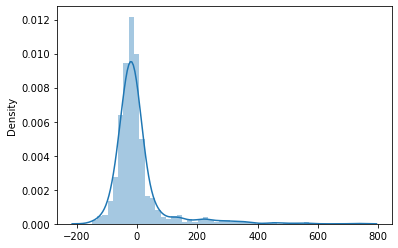

In [7]:
sns.distplot (residuals) ;

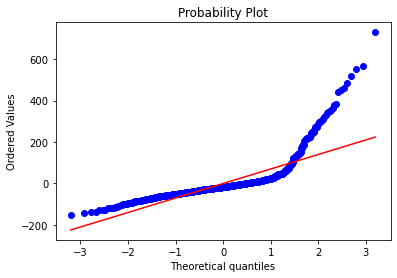

In [8]:
stats.probplot (residuals ,  plot=plt)
plt.show()

>Comments :

        * Residuals not normal
        * To achieve normal dist of residuals , apply boxcox transformation on target col.

In [9]:
df ['AE']  , lmb   =   stats.boxcox ( df ['AE'] )   

## **2. Low Multi-collinearity**

In [10]:
from   statsmodels.stats.outliers_influence   import   variance_inflation_factor   as   vif

score  =  [   vif (xc.values, i)        for i in  range(xc.shape[1])     ]

MC     =  pd.DataFrame (  {'VIF':score}  ,   index = xc.columns  )

MC.sort_values (by='VIF',ascending=False)

,VIF
const,18687.979022
T6,31.557303
T_out,29.607459
T2,28.568146
T9,27.389719
RH_2,24.640905
RH_1,19.924645
T1,18.989872
RH_4,17.301934
T7,15.784752


> Comments :
    
        * Drop cols 1 by 1 , according to highest VIF value
        * After each drop , fit & recheck VIF
        * Process is continued untill there is no relationship between input variables.

In [11]:
df .drop ( ['T6' ,'T_out' ,'T2' , 'T9' , 'RH_2' , 'RH_1' , 'T1' , 'RH_4' , 'T7' , 'RH_7'] , axis=1 , inplace=True )

In [12]:
import statsmodels.api as sm

y  =  df['AE']
x  =  df.drop('AE', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

In [13]:
residuals  =  model.resid

## **3. Homo-scedasticity**

In [14]:
import statsmodels.stats.api as sms

sms.het_goldfeldquandt ( y=residuals , x=xc )

(0.9638583963334968, 0.6573044403209587, 'increasing')

> Comments :
        
        * H0 : Equal var of residuals
        * H1 : Unequal var of residuals 
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Homo - scedastic

## **4. No Auto-correlation**

In [15]:
from  statsmodels.stats.stattools  import  durbin_watson

durbin_watson (residuals)

1.9335629899524787

* Obs
    - No auto-corr

## **5. Linearity**

In [16]:
import statsmodels.stats.api  as  sms

sms.diagnostic.linear_rainbow (model)

(0.8111714973061543, 0.9898373433898404)

> Comments :
        
        * H0 : Reg is Linear
        * H1 : Reg is not Linear.
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Reg is Linear

<a id='section_12'></a>
# Part 3 - **Model Building**

In [17]:
x  =  df.drop ('AE' , axis=1)
y  =  df ['AE']

x_train , x_test , y_train , y_test   =   train_test_split (x, y, test_size=0.3, random_state=42)

<a id='section_13'></a>
## **1 - LiR**

In [18]:
lr = LinearRegression()                                       

lr.fit (x_train , y_train)             

LinearRegression()

<a id='section_14'></a>
## **2 - RF**

In [19]:
kf  =  KFold ( n_splits =3 ,  shuffle =True ,  random_state =42 )

In [20]:
RF    =  RandomForestRegressor()

param =  { 'n_estimators':np.arange(1,30) , 'max_depth':np.arange(1,20) }

GS    =  RandomizedSearchCV (RF , param , cv=kf , scoring='r2')

GS.fit (x_train , y_train)

GS.best_params_

{'n_estimators': 23, 'max_depth': 12}

In [21]:
RF = RandomForestRegressor ( n_estimators=23 , max_depth =12 , random_state=0)  

RF.fit (x_train , y_train)

RandomForestRegressor(max_depth=7, n_estimators=18, random_state=0)

<a id='section_15'></a>
# Part 4 - **Model Selection**

In [22]:
models = []

models.append  (( 'LiR'     ,  lr      ))
models.append  (( 'RF'      ,  RF      ))

<a id='section_16'></a>
### **Fitting**

In [23]:
result = []

for i,j in models:

    print(i)
    
    y_train_pred  =  j.predict (x_train)
    y_test_pred   =  j.predict (x_test)
                   
    print  (  ( mean_squared_error  ( y_train , y_train_pred )) **0.5    )                                 
    print  (  ( mean_squared_error  ( y_test  , y_test_pred  )) **0.5    )

LiR
0.048863466140929616
0.0536248926105333
RF
0.03414370158245353
0.05392269784154538


<a id='section_17'></a>
### **Validation**

In [24]:
result = []

for  i,j  in  models:
    
    score = cross_val_score ( j , x_train , y_train , cv =kf, scoring ='r2' )
    
    result.append ( { 'Name': i   ,   'BE': np.mean(1-score)   ,   'VE': np.std(score,ddof=1)  } )                


table = pd.DataFrame(result)
table

,Name,BE,VE
0,LiR,0.751104,0.087709
1,RF,0.800080,0.085103


<a id='section_18'></a>
### **Best Model**

## *Linear Regression*